In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from anm.gaze_dataloader.dataset import _create_senteces_from_data
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
sns.set_style('darkgrid')

In [2]:
eye_tracking_feature = 'firstrun_dur'
positive_corr = True

In [3]:
def get_src_paths(source_language, target_language, method):
    meco_data_dir = '../augmenting_nlms_meco_data/'
    eye_tracking_dir = os.path.join(meco_data_dir, target_language)
    attention_extraction_output_dir = f'../output/attn_data/{task}'
    attention_dir = os.path.join(attention_extraction_output_dir, method, f'{source_language}_to_{target_language}')
    return eye_tracking_dir, attention_dir

In [4]:
def load_eye_tracking_data(src_path, col):
    data = pd.read_csv(src_path, index_col=0)
    gaze_dataset = _create_senteces_from_data(data, [col], keep_id=True)
    return gaze_dataset

In [5]:
def load_model_attention(src_path):
    with open(src_path, 'r') as src_file:
        model_attention = json.load(src_file)
    return model_attention

In [6]:
def compute_correlation(eye_tracking_dataset, model_attention_dict):
    all_human_attentions = []
    all_model_attentions = []
    feature_name = [col_name for col_name in eye_tracking_dataset.column_names if col_name not in ['id', 'text']][0]
    
    for sent_id, human_attention in zip(eye_tracking_dataset['id'], eye_tracking_dataset[feature_name]):
        model_attention = model_attention_dict[sent_id]
        all_human_attentions += human_attention
        all_model_attentions += model_attention

    s = spearmanr(all_model_attentions, all_human_attentions)
    if s.pvalue < 0.05:
        if positive_corr:
            return max(s.statistic, -s.statistic)
        else:
            return s.statistic
    else:
        return None

In [7]:
def compute_correlations_df(target_language, attention_dir, eye_tracking_dir):
    
    training_configs = os.listdir(attention_dir)
    correlations_dict = {'training_config':[], 'layer':[], 'correlation':[], 'target_user':[], 'src_user':[]}
    for training_config in training_configs:
        
        config_attention_dir = os.path.join(attention_dir, training_config)
        
        for target_user_id in os.listdir(config_attention_dir):
            eye_tracking_path = os.path.join(eye_tracking_dir, f'{target_language}_{target_user_id}_dataset.csv')
            eye_tracking_data = load_eye_tracking_data(eye_tracking_path, eye_tracking_feature)
            
            target_user_attention_dir = os.path.join(config_attention_dir, target_user_id)
            for src_user_id in os.listdir(target_user_attention_dir):
                src_user_dir = os.path.join(target_user_attention_dir, src_user_id)
                for layer in range(12):
                    layer_attention_path = os.path.join(src_user_dir, f'{layer}.json')
                    layer_attention = load_model_attention(layer_attention_path)
                    # print('training conf', training_config)
                    corr = compute_correlation(eye_tracking_data, layer_attention)
                    correlations_dict['training_config'].append(training_config)
                    correlations_dict['layer'].append(layer)
                    correlations_dict['correlation'].append(corr)
                    correlations_dict['src_user'].append(src_user_id)
                    correlations_dict['target_user'].append(target_user_id)
    return pd.DataFrame.from_dict(correlations_dict)

In [8]:
method = 'attention'
task = 'cross_lingual'
target_language = 'en'
src_language = 'it' if target_language == 'en' else 'en'

In [9]:
eye_tracking_dir, attention_dir = get_src_paths(src_language, target_language, method)
correlations_df_cl = compute_correlations_df(target_language, attention_dir, eye_tracking_dir)

In [11]:
correlations_df_cl['training_config'] = correlations_df_cl['training_config'].map(lambda x: 'cl_'+x)

In [12]:
correlations_df_cl

,training_config,layer,correlation,target_user,src_user
0,cl_pretrained_finetuned,0,NaN,6,26
1,cl_pretrained_finetuned,1,0.274081,6,26
2,cl_pretrained_finetuned,2,0.058217,6,26
3,cl_pretrained_finetuned,3,0.072381,6,26
4,cl_pretrained_finetuned,4,0.344893,6,26
...,...,...,...,...,...
595,cl_not_pretrained_finetuned,7,NaN,57,44
596,cl_not_pretrained_finetuned,8,NaN,57,44
597,cl_not_pretrained_finetuned,9,NaN,57,44
598,cl_not_pretrained_finetuned,10,NaN,57,44


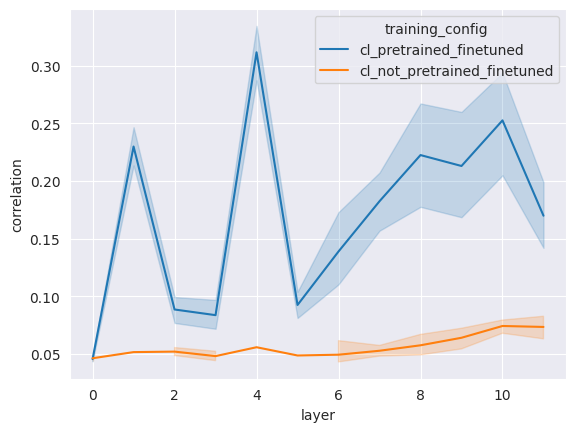

In [13]:
sns.lineplot(data=correlations_df_cl, x='layer', y='correlation', hue='training_config');

In [14]:
def compute_correlations_df_in_language(attention_dir, eye_tracking_dir):
    
    training_configs = os.listdir(attention_dir)
    correlations_dict = {'training_config':[], 'layer':[], 'correlation':[], 'user':[]}
    for training_config in training_configs:
        
        config_attention_dir = os.path.join(attention_dir, training_config)
        
        for user_id in os.listdir(config_attention_dir):
            eye_tracking_path = os.path.join(eye_tracking_dir, f'{language}_{user_id}_dataset.csv')
            eye_tracking_data = load_eye_tracking_data(eye_tracking_path, eye_tracking_feature)
            
            user_attention_dir = os.path.join(config_attention_dir, user_id)
            for layer in range(12):
                layer_attention_path = os.path.join(user_attention_dir, f'{layer}.json')
                layer_attention = load_model_attention(layer_attention_path)
                # print('training conf', training_config)
                corr = compute_correlation(eye_tracking_data, layer_attention)
                correlations_dict['training_config'].append(training_config)
                correlations_dict['layer'].append(layer)
                correlations_dict['correlation'].append(corr)
                correlations_dict['user'].append(user_id)
    return pd.DataFrame.from_dict(correlations_dict)

In [15]:
def get_src_paths_in_language(language, method, language_mode, finetuning_mode=None):
    meco_data_dir = '../augmenting_nlms_meco_data/'
    eye_tracking_dir = os.path.join(meco_data_dir, language)
    attention_extraction_output_dir = f'../output/attn_data/{task}'
    attention_dir = os.path.join(attention_extraction_output_dir, method, language, language_mode)
    return eye_tracking_dir, attention_dir

In [16]:
language = 'en'
language_mode = 'cross_lingual'
task = 'base'

In [17]:
eye_tracking_dir, attention_dir = get_src_paths_in_language(language, method, language_mode)

In [18]:
correlations_df = compute_correlations_df_in_language(attention_dir, eye_tracking_dir)

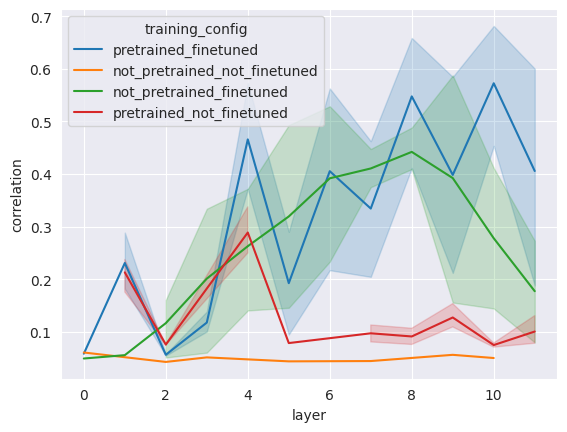

In [19]:
sns.lineplot(data=correlations_df, x='layer', y='correlation', hue='training_config');

In [26]:
filtered_correlations_df = correlations_df[correlations_df['training_config'].isin(['not_pretrained_not_finetuned', 'pretrained_not_finetuned'])]

In [27]:
# all_df = pd.concat([correlations_df, correlations_df_cl], ignore_index=True)
all_df = pd.concat([filtered_correlations_df, correlations_df_cl], ignore_index=True)

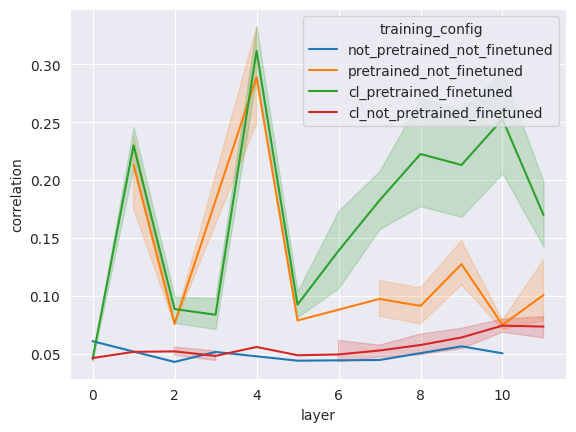

In [28]:
sns.lineplot(data=all_df, x='layer', y='correlation', hue='training_config');